## !!! use conda environment: tensorforce

In [20]:
%%script cmd --bg --out asdf
start tensorboard --host localhost --logdir C:/users/vogi23/checkpoints/000/tb

In [1]:
%load_ext autoreload
%autoreload 2D

In [2]:
import sys
sys.path.append("../packages")
import os
import numpy as np
import matplotlib.pyplot as plt
import gym
import collections

import floorplan

import warnings
warnings.filterwarnings('ignore')

# LoopWalkerCubeWorld V3

V3 is only a wrapper to reshape the returned state to (h,w,rooms)


In [3]:
gridSize=20
targetArea=[9,12]
wallCost = 0.1
cornerCost = 0.4 * 4
failCost = 3
env = gym.make('LoopWalkerCubeWorld-v3')
env.setup(h=gridSize,w=gridSize,a=targetArea,wallCost=wallCost, cornerCost=cornerCost, failCost=failCost)

6.100000000000003


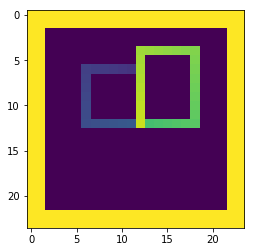

In [4]:
r = 0
env.reset()
r += env.step(0)[1]
r += env.step(0)[1]
r += env.step(0)[1]
r += env.step(1)[1]
r += env.step(1)[1]
r += env.step(1)[1]
r += env.step(2)[1]
r += env.step(2)[1]
r += env.step(2)[1]
r += env.step(3)[1]
r += env.step(3)[1]
r += env.step(3)[1]
r += env.step(3)[1]
r += env.step(3)[1]
r += env.step(3)[1]
r += env.step(0)[1]
r += env.step(0)[1]
r += env.step(0)[1]
r += env.step(0)[1]
r += env.step(1)[1]
r += env.step(1)[1]
r += env.step(1)[1]
r += env.step(2)[1]
r += env.step(2)[1]
r += env.step(2)[1]
r += env.step(0)[1]
r += env.step(2)[1]
plt.imshow(env.render())
print(r)

## DQN with CNN using tensorforce

In [5]:
import logging
import json
import os
import time
import sys

from tensorforce import TensorForceError
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym

import gym.wrappers

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [6]:
agent_config_file = './configs/000_dqn.json'
network_config_file = './configs/000_cnn_dqn_network.json'

environment = OpenAIGym(
    gym_id='LoopWalkerCubeWorld-v3'
)

# load agent config
with open(agent_config_file, 'r') as fp:
    agent_config = json.load(fp=fp)

# load network config
with open(network_config_file, 'r') as fp:
        network_config = json.load(fp=fp)



In [7]:
# create agent
agent = Agent.from_spec(
    spec=agent_config,
    kwargs=dict(
        states=environment.states,
        actions=environment.actions,
        network=network_config
    )
)


logger.info("-" * 16)
logger.info("Configuration:")
logger.info(agent)

runner = Runner(
    agent=agent,
    environment=environment,
    repeat_actions=1
)

logger.info("Starting {agent} for Environment '{env}'".format(agent=agent, env=environment))
report_episodes = 100

def episode_finished(r, id_):
    if r.episode % report_episodes == 0:
        steps_per_second = r.timestep / (time.time() - r.start_time)
        logger.info("Finished episode {:d} after {:d} timesteps ({:d} timesteps total). Steps Per Second {:0.2f}".format(
            r.agent.episode, r.episode_timestep, r.agent.timestep, steps_per_second
        ))
        logger.info("Episode reward: {}".format(r.episode_rewards[-1]))
        logger.info("Average of last 500 rewards: {:0.2f}".
                    format(sum(r.episode_rewards[-500:]) / min(500, len(r.episode_rewards))))
        logger.info("Average of last 100 rewards: {:0.2f}".
                    format(sum(r.episode_rewards[-100:]) / min(100, len(r.episode_rewards))))
    return True

INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:/Users/vogi23/checkpoints/000/model/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:/Users/vogi23/checkpoints/000/model/model.ckpt.
INFO:root:----------------
INFO:root:Configuration:
INFO:root:DQNAgent
INFO:root:Starting DQNAgent for Environment 'OpenAIGym(LoopWalkerCubeWorld-v3)'


# (Re-) Train agent

In [17]:
runner.run(
    num_timesteps=100000,
    max_episode_timesteps=25,
    episode_finished=episode_finished,
    testing=False
)
#runner.close()

logger.info("Learning finished. Total episodes: {ep}".format(ep=runner.agent.episode))

INFO:root:Learning finished. Total episodes: 61


# Load the trained model

In [21]:
# Load the model
agent.restore_model("C:/Users/vogi23/checkpoints/000/model/")

INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/000/model/model.ckpt-0


INFO:tensorflow:Restoring parameters from C:/Users/vogi23/checkpoints/000/model/model.ckpt-0


## Testing the agent

INFO:root:----------------
INFO:root:Configuration:
INFO:root:DQNAgent


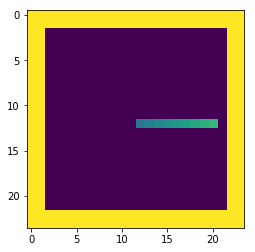

In [56]:
logger.info("-" * 16)
logger.info("Configuration:")
logger.info(agent)

runner = Runner(
    agent=agent,
    environment=environment,
    repeat_actions=1
)

runner.run(
    num_episodes=1,
    max_episode_timesteps=50,
    testing=True,
    deterministic=True
)

plt.imshow(runner.environment.gym.render())

Result looks quite similar to notebook 21 and 22.

Unfortunately due to the generic implementation of TensorForce (and its abstract internal build of the networks) its very hard to debug and visualize activations of the layers.